# Creating ONNX models from scratch

[Open Neural Network Exchange (ONNX)](https://onnx.ai/) is an open format created to share neural networks created by different deep learning (DL) frameworks. It defines a set of operators (Add, MatMul, Conv, etc.), a standard file format to exchange the model ([protobuf](https://github.com/protocolbuffers/protobuf) is used), and a runtime to make inferences. Even accelerators are available using [execution providers](https://onnxruntime.ai/docs/execution-providers/) like CUDA, OpenVINO, CoreML, etc, for the runtime.

With ONNX, we can train a model using Tensorflow, convert the trained model to ONNX, and use it from any programming language where the ONNX runtime is available.

This notebook will show how to create a model from scratch. Usually, we use a [converter](https://onnx.ai/onnx/intro/converters.html) to translate from a DL framework, but I won't use any.
The idea is to show how it works. We will create a model to calculate the following equation:

**_Y = (X * A) + (T * A) + B_**


First, we must install the package with the following command and then import some modules.

_NOTE: this notebook content is based on the official ONNX documentation._

In [ ]:
%pip install onnx

In [1]:
import numpy as np
from onnx import TensorProto, numpy_helper
from onnx.checker import check_model
from onnx.helper import make_model, make_node, make_graph, make_tensor_value_info

An ONNX model is composed of:

1. a set of input Tensors.
2. a set of output Tensors.
3. a set of nodes, where each node is of a type and represents an action to be taken (Add, MatMul, Conv, etc).
4. connections between the nodes.
5. initialized variables created during the training process.

From data structures, we call it a [**directed acyclic graph (DAG)**](https://en.wikipedia.org/wiki/Directed_acyclic_graph).

A Tensor has a **type** and a **shape**. The **type** defines the ranges of values allowed for all elements in the Tensor (FLOAT32, FLOAT64, etc.), and the **shape** defines how many dimensions the Tensor has and the number of elements at each dimension.

The code below defines five Tensors. The type of them is **FLOAT**, and the shape has two dimensions with two elements at each.

In [2]:
A = make_tensor_value_info('A', TensorProto.FLOAT, [2, 2])
B = make_tensor_value_info('B', TensorProto.FLOAT, [2, 2])
T = make_tensor_value_info('T', TensorProto.FLOAT, [2, 2])
X = make_tensor_value_info('X', TensorProto.FLOAT, [2, 2])
Y = make_tensor_value_info('Y', TensorProto.FLOAT, [2, 2])

Now, let's define the nodes. The code below does that, and in this case, we are creating two nodes to execute a matrix multiplication (one node for X * A and another for T * A). 
The result of both nodes will be added together, and the result will be added to B, generating Y.

As already said, ONNX provides several different operators for the common operations in DL. You can find the list of operators [here](https://onnx.ai/onnx/operators/).
At each new version, ONNX adds more operators, and the supported operators are represented by an operator set id, called **opset**. So, if you have a model where the opset is 19, the ONNX runtime must support at least this version to execute the model.

In [3]:
# Create multiXA and multiTA nodes, which will multiply X and A, and T and A . The results will be stored in XA and TA.
multiXA = make_node('MatMul', ['X', 'A'], ['XA'])
multiTA = make_node('MatMul', ['T', 'A'], ['TA'])

# Create addXATA and addXATAB, which will add XA (the previous result) and B. The result will be stored in Y.
addXATA  = make_node('Add', ['XA', 'TA'], ['XATA'])
addXATAB = make_node('Add', ['XATA', 'B'], ['Y'])


The final component is the graph where the nodes, inputs and outputs are connected.

In [4]:
graph = make_graph(
    [multiXA, multiTA, addXATA, addXATAB],                  # nodes
    'sample equation',                                      # name
    [X, T, A, B],                                           # inputs
    [Y, A],                                                 # outputs
    doc_string = 'calculate Y = (X * A) + (T * A) + B'      # docstring
)  

Create the ONNX model, check its consistency, and print its architecture. An intermediate representation (IR) is created for the model with all the details. This is the model representation.

In [5]:
onnx_model = make_model(graph)

onnx_model.model_version = 4
onnx_model.producer_name  = "glzbcrt"
onnx_model.producer_version = "2.3"

check_model(onnx_model)
print(onnx_model)

ir_version: 9
producer_name: "glzbcrt"
producer_version: "2.3"
model_version: 4
graph {
  node {
    input: "X"
    input: "A"
    output: "XA"
    op_type: "MatMul"
  }
  node {
    input: "T"
    input: "A"
    output: "TA"
    op_type: "MatMul"
  }
  node {
    input: "XA"
    input: "TA"
    output: "XATA"
    op_type: "Add"
  }
  node {
    input: "XATA"
    input: "B"
    output: "Y"
    op_type: "Add"
  }
  name: "sample equation"
  doc_string: "calculate Y = (X * A) + (T * A) + B"
  input {
    name: "X"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 2
          }
          dim {
            dim_value: 2
          }
        }
      }
    }
  }
  input {
    name: "T"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 2
          }
          dim {
            dim_value: 2
          }
        }
      }
    }
  }
  input {
    name: "A"
    type {
      tensor_type {

Save the model as **model.onnx**, and load it on [Netron](https://netron.app/) to visualize.

In [25]:
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

The screenshot below shows the model we created. As you can see, the inputs, outputs, nodes, and connections are all listed.
We can also see that a model can have any number of inputs and outputs.

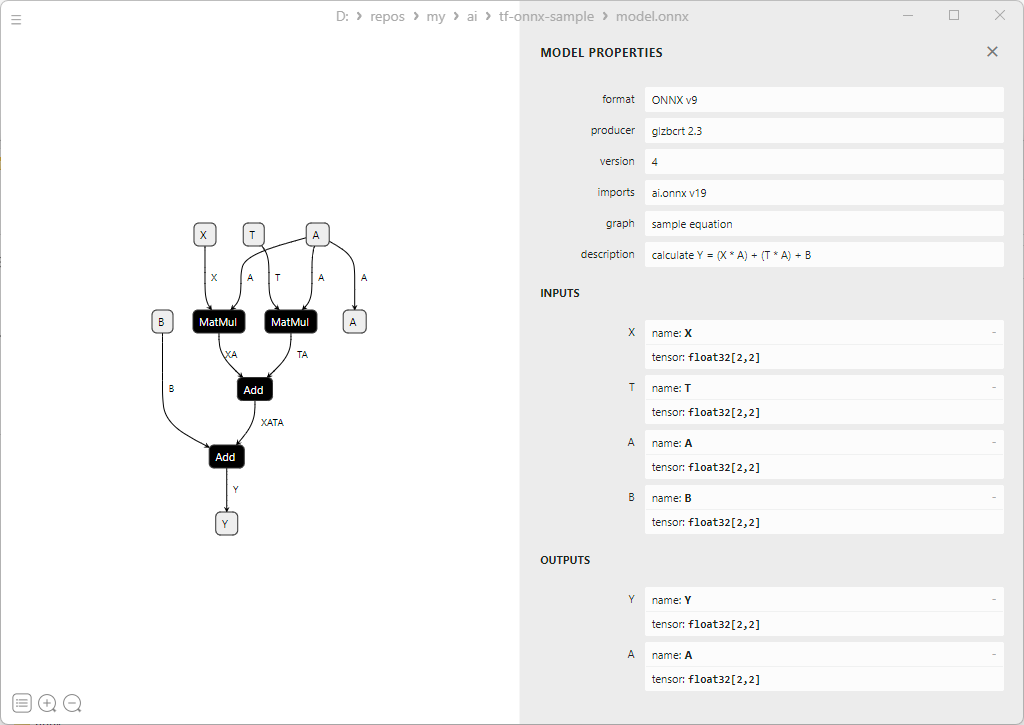

However, the model we created does not contain any data learned during the training process. It will only execute the nodes and expect all the parameters (A, B, X, and T) to be provided externally.
However, when we train a model using an optimizer algorithm, a loss algorithm, and lots of data, we will find the best values for these parameters, in this case, A, B, X, and T.

To have a fully working mode,l we need to copy this "knowledge" to the model. Let's do it!

We are using the same model we previously created, but in this version, the tensors A and B will have their values inside the model.
Only the inputs T and X will need to be provided externally.

In this case, we are converting two numpy arrays (A and B) as ONNX tensors. These two arrays have two dimensions with two values.
Note that the values will be contained inside the **raw_data** property in the intermediate representation. It is up to the ONNX runtime to extract this data.

In [3]:

A = numpy_helper.from_array(
    np.array([
        [3.0, 5.0],
        [1.0, 2.0],
    ], dtype=np.float32), 
    name='A'
)

B = numpy_helper.from_array(
    np.array([
        [4.0, 6.0],
        [7.0, 8.0],
    ], dtype=np.float32), 
    name='B'
)

T = make_tensor_value_info('T', TensorProto.FLOAT, [2, 2])
X = make_tensor_value_info('X', TensorProto.FLOAT, [2, 2])
Y = make_tensor_value_info('Y', TensorProto.FLOAT, [2, 2])

# Create multiXA and multiTA nodes, which will multiply X and A, and T and A . The results will be stored in XA and TA.
multiXA = make_node('MatMul', ['X', 'A'], ['XA'])
multiTA = make_node('MatMul', ['T', 'A'], ['TA'])

# Create addXATA and addXATAB, which will add XA (the previous result) and B. The result will be stored in Y.
addXATA  = make_node('Add', ['XA', 'TA'], ['XATA'])
addXATAB = make_node('Add', ['XATA', 'B'], ['Y'])

node1 = make_node('MatMul', ['X', 'A'], ['AX'])
node2 = make_node('Add', ['AX', 'B'], ['Y'])

graph = make_graph(
    [multiXA, multiTA, addXATA, addXATAB],                  # nodes
    'sample equation',                                      # name
    [X, T],                                                 # inputs
    [Y],                                                    # outputs
    [A, B],                                                 # initializers
    doc_string = 'calculate Y = (X * A) + (T * A) + B'      # docstring
)    

onnx_model = make_model(graph)

onnx_model.model_version = 4
onnx_model.producer_name  = "glzbcrt"
onnx_model.producer_version = "2.3"

check_model(onnx_model)
print(onnx_model)


ir_version: 9
producer_name: "glzbcrt"
producer_version: "2.3"
model_version: 4
graph {
  node {
    input: "X"
    input: "A"
    output: "XA"
    op_type: "MatMul"
  }
  node {
    input: "T"
    input: "A"
    output: "TA"
    op_type: "MatMul"
  }
  node {
    input: "XA"
    input: "TA"
    output: "XATA"
    op_type: "Add"
  }
  node {
    input: "XATA"
    input: "B"
    output: "Y"
    op_type: "Add"
  }
  name: "sample equation"
  initializer {
    dims: 2
    dims: 2
    data_type: 1
    name: "A"
    raw_data: "\000\000@@\000\000\240@\000\000\200?\000\000\000@"
  }
  initializer {
    dims: 2
    dims: 2
    data_type: 1
    name: "B"
    raw_data: "\000\000\200@\000\000\300@\000\000\340@\000\000\000A"
  }
  doc_string: "calculate Y = (X * A) + (T * A) + B"
  input {
    name: "X"
    type {
      tensor_type {
        elem_type: 1
        shape {
          dim {
            dim_value: 2
          }
          dim {
            dim_value: 2
          }
        }
      }
    }

Save the model again. Open it on Netron and view the model structure.

In [4]:
with open("model_initializers.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

Now that two inputs have been converted to have their values stored inside the model, we do not need them externally, the general architecture of the model changed a little bit.
The image below shows the new architecture and the values for the B tensor inside the model.

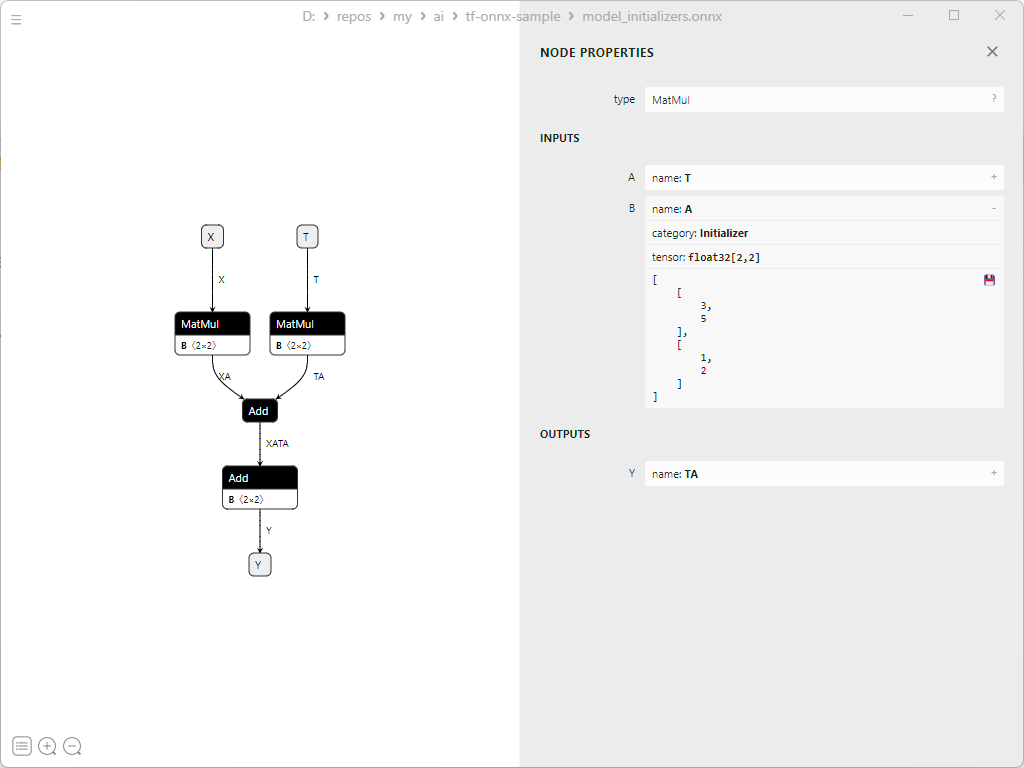

An ONNX converter, like [tensorflow-onnx](https://github.com/onnx/tensorflow-onnx), will take a model and, using this API shown here, convert it to an ONNX model. This ONNX model can then be used by any language with an ONNX runtime available to make inferences.

The advantage is that we can use any framework (Tensorflow, PyTorch, MXNet, etc) to create, train a model, and then use a totally different programming language to make inferences.

**Hope you enjoyed this notebook!** 😀
